In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-f316a09e-31cc-5d9c-d08f-dec5774f2b3c)


In [2]:
!pip install -q -U einops
!pip install -q datasets
!pip install -q ema-pytorch
!pip install --upgrade -q wandb
!pip install 'git+https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup' -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.10.1 requires wandb<0.13.0,>=0.10.0, but you have wandb 0.13.5 which is incompatible.


In [3]:
import random
import math
import requests
from pathlib import Path

from functools import partial
from enum import Enum

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm.notebook import tqdm

import torch
from torch import einsum
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from einops import rearrange, reduce
from ema_pytorch import EMA

from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from torchvision.utils import save_image

from cosine_annealing_warmup import CosineAnnealingWarmupRestarts

from datasets import load_dataset
from huggingface_hub import PyTorchModelHubMixin

import wandb


def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)


## Sinusoidal Pos Embedding

In [4]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

In [5]:
class SinusoidalPositionEmbeddingsInterleaved(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        embeddings = math.log(10000) / self.dim
        embeddings = torch.exp(torch.arange(self.dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings[:, 0::2] = embeddings[:, 0::2].sin()
        embeddings[:, 1::2] = embeddings[:, 1::2].cos()
        return embeddings


In [6]:
# SinusoidalPositionEmbeddings(8)(torch.tensor([[2],[3]])).shape # B, C, Time_emb_dim

## Model

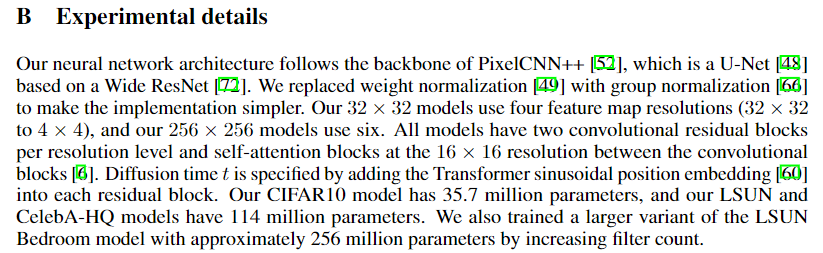

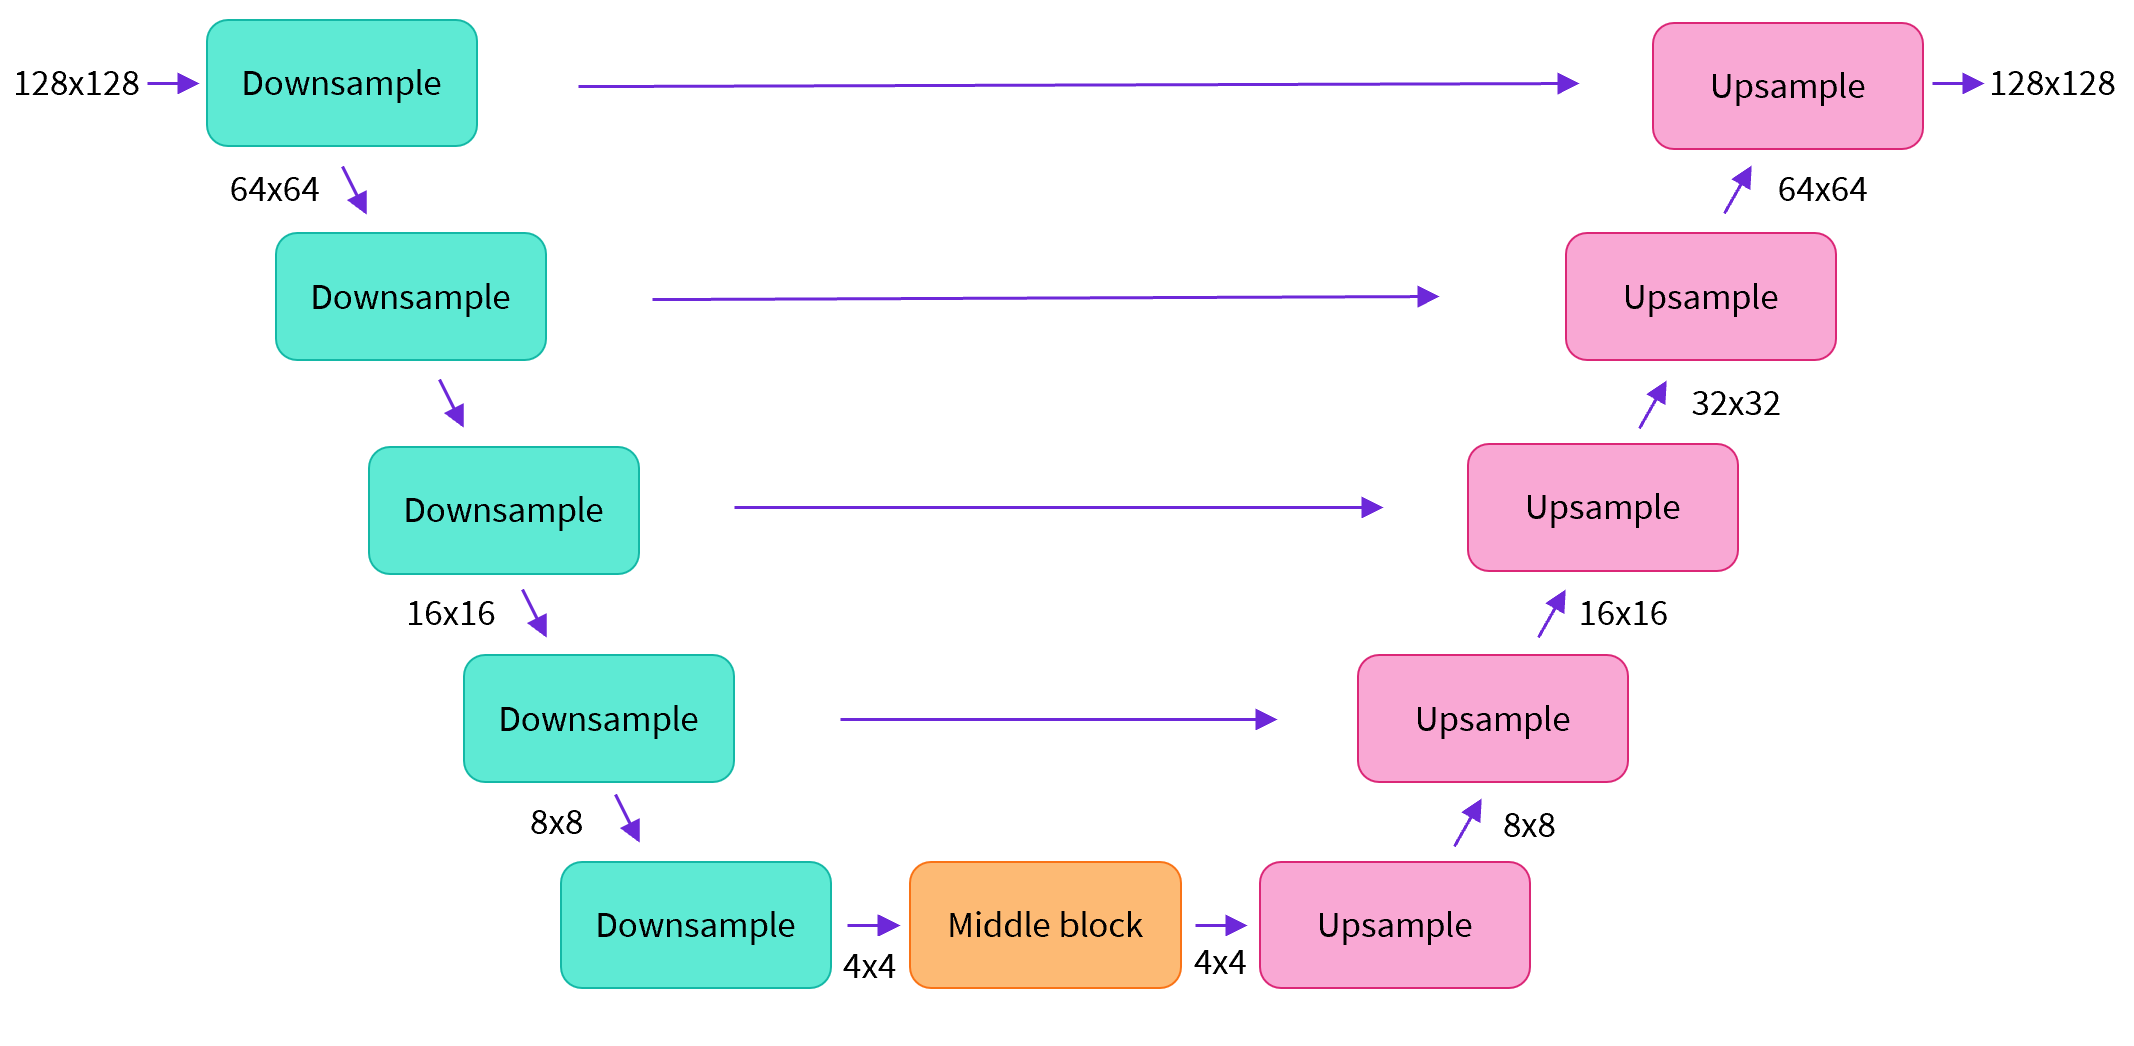

In [7]:
class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """
    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        flattened_weights = rearrange(weight, 'o ... -> o (...)')

        mean = reduce(weight, 'o ... -> o 1 1 1', 'mean')

        var = torch.var(flattened_weights, dim = -1, unbiased = False)
        var = rearrange(var, 'o -> o 1 1 1')

        weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv2d(x, weight, self.bias, self.stride, 
                        self.padding, self.dilation, self.groups)


class ResNetBlock(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels,
                 time_emb_dim,
                 conv_type=nn.Conv2d,
                 groups=8,
                 conv_drop=0.2,
                 activation=nn.SiLU):
        super().__init__()
        self.in_channels = in_channels
        self.conv_op = conv_type
        self.conv_drop = conv_drop
        self.mlp = (nn.Sequential(activation(), 
                                  nn.Linear(time_emb_dim, out_channels * 2)) # <--
                                  if time_emb_dim is not None
                                  else None)
        self.conv1 = self.conv_op(in_channels, 
                                  out_channels, 
                                  kernel_size=3, 
                                  stride=1,
                                  padding=1, 
                                  bias=False)
        self.norm1 = nn.GroupNorm(groups, out_channels)
        self.dropout_1 = nn.Dropout(self.conv_drop, True)
        self.activation = activation()
        self.conv2 = self.conv_op(out_channels, 
                                  out_channels, 
                                  kernel_size=3, 
                                  stride=1, 
                                  padding=1,
                                  bias=False)
        self.norm2 = nn.GroupNorm(groups, out_channels)
        self.dropout_2 = nn.Dropout(self.conv_drop, True)
        self.res_conv = (   
            self.conv_op(in_channels, out_channels, 1) 
            if in_channels != out_channels 
            else nn.Identity()
        )

    def forward(self, x, time_emb=None):
        identity = x
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.activation(x)
        x = self.dropout_1(x)

        if self.mlp is not None and time_emb is not None:
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, "b c -> b c 1 1")    # <--
            scale, shift = time_emb.chunk(2, dim=1)             # <--
            x = x * (scale + 1) + shift                         # <--
            # x = rearrange(time_emb, "b c -> b c 1 1") + x     # <--
        
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.activation(x)
        x = self.dropout_2(x)

        x += self.res_conv(identity)
        return x


class ConvNeXtBlock(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels,
                 time_emb_dim,
                 conv_drop=0.2,
                 conv_type=nn.Conv2d,
                 activation=nn.GELU):
        super().__init__()
        self.in_channels = in_channels
        self.conv_drop = conv_drop
        self.conv_op = conv_type
        self.mlp = (nn.Sequential(activation(), 
                                  nn.Linear(time_emb_dim, in_channels))
                                  if time_emb_dim is not None
                                  else None)
        self.conv1 = self.conv_op(in_channels, 
                                  in_channels, 
                                  kernel_size=7,
                                  stride=1,
                                  padding=3,
                                  groups=in_channels,
                                  bias=True)
        self.norm1 = nn.GroupNorm(1, in_channels)
        self.activation = activation()
        self.dropout_1 = nn.Dropout(self.conv_drop)
        self.conv2 = self.conv_op(in_channels, 
                                  in_channels * 4, 
                                  kernel_size=1, 
                                  stride=1, 
                                  padding=0,
                                  bias=True)

        self.conv3 = self.conv_op(in_channels * 4, 
                                  out_channels, 
                                  kernel_size=1, 
                                  stride=1, 
                                  padding=0,
                                  bias=True)

        self.res_conv = (
            self.conv_op(in_channels, out_channels, 1) 
            if in_channels != out_channels 
            else nn.Identity()
        )

    def forward(self, x, time_emb=None):
        identity = x
        x = self.conv1(x)
        x = self.norm1(x)

        if self.mlp is not None and time_emb is not None:
            time_emb = self.mlp(time_emb)
            x = rearrange(time_emb, "b c -> b c 1 1") + x
        
        x = self.conv2(x)
        x = self.activation(x)
        x = self.dropout_1(x)

        x = self.conv3(x)
        x += self.res_conv(identity)
        return x


def Upsample(channels):
    return nn.ConvTranspose2d(channels, 
                              channels, 
                              kernel_size=4, 
                              stride=2, 
                              padding=1)


def Downsample(channels):
    return nn.Conv2d(channels, 
                     channels, 
                     kernel_size=4, 
                     stride=2, 
                     padding=1)


class Attention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads

        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q * self.scale

        sim = einsum('b h d i, b h d j -> b h i j', q, k)
        attn = sim.softmax(dim = -1)
        out = einsum('b h i j, b h d j -> b h i d', attn, v)

        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x = h, y = w)
        return self.to_out(out)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)


class Unet(nn.Module, PyTorchModelHubMixin):
    def __init__(self, 
                 input_channels=3, 
                 block_type=ResNetBlock,
                 conv_type=nn.Conv2d,
                 attention_type=LinearAttention,
                 dim=16,
                 time_emb_dim=128):
        super().__init__()
        self.dim = dim
        self.time_emb_dim = time_emb_dim
        self.input_channels = input_channels
        self.conv_op = conv_type
        self.block = block_type
        if time_emb_dim:
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(self.time_emb_dim // 4),
                nn.Linear(self.time_emb_dim // 4, self.time_emb_dim),
                nn.GELU(),
                nn.Linear(self.time_emb_dim, self.time_emb_dim),
            )
        else:
            self.time_emb_dim = None
            self.time_mlp = None

        self.conv1 = self.conv_op(self.input_channels, 
                               self.dim, 
                               kernel_size=7, # 3
                               padding=3) # 1
        self.downsample_blocks = nn.ModuleList([
            nn.ModuleList([self.block(self.dim, self.dim, self.time_emb_dim, conv_type=self.conv_op),
                          self.block(self.dim, self.dim * (2 ** 1), self.time_emb_dim, conv_type=self.conv_op),
                          nn.GroupNorm(1, self.dim * (2 ** 1)),
                          nn.Identity(), # attention_type(dim=32, heads=4, dim_head=32),
                          Downsample(self.dim * (2 ** 1))]), # to IMG_SIZE // 2
            nn.ModuleList([self.block(self.dim * (2 ** 1), self.dim * (2 ** 1), self.time_emb_dim, conv_type=self.conv_op),
                          self.block(self.dim * (2 ** 1), self.dim * (2 ** 2), self.time_emb_dim, conv_type=self.conv_op),
                          nn.GroupNorm(1, self.dim * (2 ** 2)),
                          nn.Identity(), # attention_type(dim=self.dim * (2 ** 2), heads=4, dim_head=32),
                          Downsample(self.dim * (2 ** 2))]), # to IMG_SIZE // 4
            nn.ModuleList([self.block(self.dim * (2 ** 2), self.dim * (2 ** 2), self.time_emb_dim, conv_type=self.conv_op),
                          self.block(self.dim * (2 ** 2), self.dim * (2 ** 3), self.time_emb_dim, conv_type=self.conv_op),
                          nn.GroupNorm(1, self.dim * (2 ** 3)),
                          attention_type(dim=self.dim * (2 ** 3), heads=4, dim_head=32),
                          Downsample(self.dim * (2 ** 3))]), # to IMG_SIZE // 8
            nn.ModuleList([self.block(self.dim * (2 ** 3), self.dim * (2 ** 3), self.time_emb_dim, conv_type=self.conv_op),
                          self.block(self.dim * (2 ** 3), self.dim * (2 ** 4), self.time_emb_dim, conv_type=self.conv_op),
                          nn.GroupNorm(1, self.dim * (2 ** 4)),
                          attention_type(dim=self.dim * (2 ** 4), heads=4, dim_head=32),
                          Downsample(self.dim * (2 ** 4))]), # to IMG_SIZE // 16
        ])
        self.middle_block = self.block(self.dim * (2 ** 4), self.dim * (2 ** 4), self.time_emb_dim)
        self.middle_norm = nn.GroupNorm(1, self.dim * (2 ** 4))
        self.middle_attention = attention_type(dim=self.dim * (2 ** 4), heads=4, dim_head=32)
        self.upsample_blocks = nn.ModuleList([
            nn.ModuleList([self.block(self.dim * (2 ** 4), self.dim * (2 ** 4), self.time_emb_dim, conv_type=self.conv_op),
                          self.block(self.dim * (2 ** 4), self.dim * (2 ** 3), self.time_emb_dim, conv_type=self.conv_op),
                          nn.GroupNorm(1, self.dim * (2 ** 3)),
                          attention_type(dim=self.dim * (2 ** 3), heads=4, dim_head=32),
                          Upsample(self.dim * (2 ** 3))]), # to IMG_SIZE * 2
            nn.ModuleList([self.block(self.dim * (2 ** 3), self.dim * (2 ** 3), self.time_emb_dim, conv_type=self.conv_op),
                          self.block(self.dim * (2 ** 3), self.dim * (2 ** 2), self.time_emb_dim, conv_type=self.conv_op),
                          nn.GroupNorm(1, self.dim * (2 ** 2)),
                          attention_type(dim=self.dim * (2 ** 2), heads=4, dim_head=32),
                          Upsample(self.dim * (2 ** 2))]), # to IMG_SIZE * 4
            nn.ModuleList([self.block(self.dim * (2 ** 2), self.dim * (2 ** 2), self.time_emb_dim, conv_type=self.conv_op),
                          self.block(self.dim * (2 ** 2), self.dim * (2 ** 1), self.time_emb_dim, conv_type=self.conv_op),
                          nn.GroupNorm(1, self.dim * (2 ** 1)),
                          nn.Identity(), # attention_type(dim=self.dim * (2 ** 1), heads=4, dim_head=32),
                          Upsample(self.dim * (2 ** 1))]), # to IMG_SIZE * 8
            nn.ModuleList([self.block(self.dim * (2 ** 1), self.dim * (2 ** 1), self.time_emb_dim, conv_type=self.conv_op),
                          self.block(self.dim * (2 ** 1), self.dim, self.time_emb_dim, conv_type=self.conv_op),
                          nn.GroupNorm(1, self.dim),
                          nn.Identity(), # attention_type(dim=16, heads=4, dim_head=32),
                          Upsample(self.dim)]), # to IMG_SIZE * 16
        ])
        self.final_conv = self.conv_op(self.dim, self.input_channels, 1)
        # self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.LayerNorm) or isinstance(module, nn.GroupNorm):
            nn.init.constant_(module.weight, 1)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        if isinstance(module, nn.Conv2d):
            nn.init.xavier_normal_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)

    def forward_encoder(self, x, time_emb=None):
        residuals = []
        for block1, block2, norm, attention, downsample in self.downsample_blocks:
            x = block1(x, time_emb)
            x = block2(x, time_emb)
            x = x + norm(attention(x))
            x = downsample(x)
            residuals.append(x)
        return x, residuals

    def forward_decoder(self, x, residuals, time_emb=None):
        for (block1, block2, norm,
             attention, upsample), residual in zip(self.upsample_blocks, \
                                                                   reversed(residuals)):
            x = x + residual
            x = block1(x, time_emb)
            x = block2(x, time_emb)
            x = x + norm(attention(x))
            x = upsample(x)
            
        return x
    
    def forward(self, x, time):
        time_emb = self.time_mlp(time) if self.time_mlp is not None else None
        x = self.conv1(x)
        x, residuals = self.forward_encoder(x, time_emb)
        # residuals = [res for res in reversed(residuals)]
        x = x + self.middle_norm(self.middle_attention(self.middle_block(x, time_emb)))
        x = self.forward_decoder(x, residuals, time_emb)
        x = self.final_conv(x)
        # x = nn.Tanh()(x)
        return x


class Conditional_Unet(Unet):
    def __init__(self, 
                 input_channels=3, 
                 block_type=ConvNeXtBlock,
                 conv_type=nn.Conv2d,
                 attention_type=LinearAttention, 
                 time_emb_dim=128, 
                 num_classes=None):
        super().__init__(input_channels=input_channels, 
                         block_type=block_type,
                         conv_type=conv_type,
                         attention_type=attention_type, 
                         time_emb_dim=time_emb_dim)
        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_emb_dim)


    def forward(self, x, t, y=None):
        # t = t.unsqueeze(-1)
        t = self.pos_encoding(t, self.time_dim)

        if y is not None:
            t += self.label_emb(y)

        return self.unet_forwad(x, t)




In [8]:
device = 'cpu'
x = torch.randn([2, 3, 32, 32]).to(device)
t = torch.randint(0, 999, (2,), device=device).long()

In [9]:
m = Unet(input_channels=3, dim=32, block_type=ResNetBlock, conv_type=nn.Conv2d).to(device)

print(m(x, t).shape)
print(m(x, t).device)
print(sum([p.numel() for p in m.parameters()]))
# print(m)
del m

torch.Size([2, 3, 32, 32])
cpu
28691811


## Diffuser

<img src="https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM.png" alt="Sampling" width="750"/>

In [10]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps, s=1):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps*s)[::s]


$$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$$

\begin{aligned}
\mathbf{x}_t 
&= \sqrt{\alpha_t}\mathbf{x}_{t-1} + \sqrt{1 - \alpha_t}\boldsymbol{\epsilon}_{t-1} & \text{ ;where } \boldsymbol{\epsilon}_{t-1}, \boldsymbol{\epsilon}_{t-2}, \dots \sim \mathcal{N}(\mathbf{0}, \mathbf{I}) \\
&= \sqrt{\alpha_t \alpha_{t-1}} \mathbf{x}_{t-2} + \sqrt{1 - \alpha_t \alpha_{t-1}} \bar{\boldsymbol{\epsilon}}_{t-2} & \text{ ;where } \bar{\boldsymbol{\epsilon}}_{t-2} \text{ merges two Gaussians (*).} \\
&= \dots \\
&= \sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon} \\
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned}

$$\alpha_t = 1 - \beta_t$$

$$\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$$

$$q(\mathbf{x}_{t-1} \vert \mathbf{x}_t, \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_{t-1}; \color{blue}{\tilde{\boldsymbol{\mu}}}(\mathbf{x}_t, \mathbf{x}_0), \color{red}{\tilde{\beta}_t} \mathbf{I})$$

\begin{aligned}
\boldsymbol{\mu}_\theta(\mathbf{x}_t, t) &= {\frac{1}{\sqrt{\alpha_t}} \Big( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t) \Big)} \\
\text{Thus }\mathbf{x}_{t-1} &= \mathcal{N}(\mathbf{x}_{t-1}; \frac{1}{\sqrt{\alpha_t}} \Big( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t) \Big), \boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t))
\end{aligned}

In [11]:
timesteps = 1000

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps) # β

# define alphas 
alphas = 1. - betas # α
alphas_cumprod = torch.cumprod(alphas, axis=0) # α_bar
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) # α_bar(t-1)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas) # √(1/α)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod) # √(α_bar)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod) # √(1 - α_bar)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod) # β * ((1 - α_bar(t-1)) / (1 - α_bar(t)))

def extract(a, t, x_shape):
    # batch_size = t.shape[0]
    # out = a.gather(-1, t.cpu()) # gather items along last dimensions of a (4D) with index from tensor t (1 D), result should also be 1D
    # extract_result = out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device) # reshape the 1D tensor to (batch_size, *other_dims) (4D)
    extract_result = a[t, None, None, None].to(t.device)
    return extract_result 


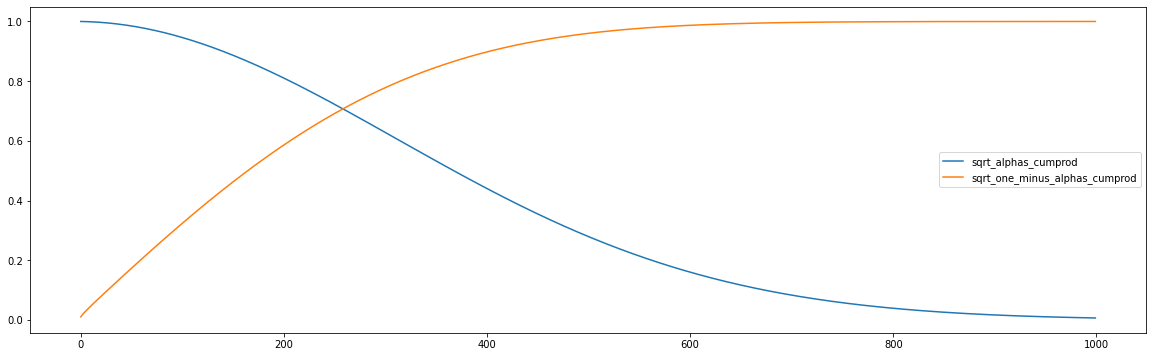

In [12]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(6)
plt.plot(sqrt_alphas_cumprod, label='sqrt_alphas_cumprod')
plt.plot((sqrt_one_minus_alphas_cumprod), label='sqrt_one_minus_alphas_cumprod')
plt.legend();

In [13]:
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# image = Image.open(requests.get(url, stream=True).raw)

In [14]:
image_size = 128

transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(),
    Lambda(lambda t: (t * 2) - 1), 
])

# x_start = transform(image).unsqueeze(0)
# x_start.shape


In [15]:
reverse_transform = Compose([
    Lambda(lambda t: (t + 1) / 2),
    Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
    Lambda(lambda t: t * 255.),
    Lambda(lambda t: t.numpy().astype(np.uint8)),
    ToPILImage(),
])


\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned}

\begin{aligned}
\mathbf{z} &= \boldsymbol{\mu} + \boldsymbol{\sigma} \odot \boldsymbol{\epsilon} \text{, where } \boldsymbol{\epsilon} \sim \mathcal{N}(0, \boldsymbol{I}) & \scriptstyle{\text{; Reparameterization trick.}}
\end{aligned}

In [16]:
# forward diffusion (using the nice property)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    # sqrt_alphas_cumprod.reshape(x_start.shape[0], *((1,) * (len(x_start.shape) - 1)))
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise


In [17]:
def get_noisy_image(x_start, t):
    # add noise
    x_noisy = q_sample(x_start, t=t)
    
    # turn back into PIL image
    noisy_image = reverse_transform(x_noisy.squeeze())
    
    return noisy_image


In [18]:
# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()


In [19]:
# plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 19, 39, 59, 79, 99, 199]])

<img src="https://huggingface.co/blog/assets/78_annotated-diffusion/sampling.png" alt="Sampling" width="550"/>

In [20]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    # imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        # imgs.append(img.cpu().numpy())
    return img.cpu().numpy() # imgs

@torch.no_grad()
def sample(model, image_size, batch_size=32, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))


<img src="https://huggingface.co/blog/assets/78_annotated-diffusion/training.png" alt="Training" width="600"/>

In [21]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l2"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    with torch.autocast(device_type="cuda", dtype=torch.float16):
        predicted_noise = denoise_model(x_noisy, t)
        if loss_type == 'l1':
            loss = F.l1_loss(noise, predicted_noise)
        elif loss_type == 'l2':
            loss = F.mse_loss(noise, predicted_noise)
        elif loss_type == "huber":
            loss = F.smooth_l1_loss(noise, predicted_noise)
        else:
            raise NotImplementedError()

    return loss


In [22]:
def save(milestone, step, model, opt, ema, scaler, results_folder):
    data = {
        'step': step,
        'model': model.state_dict(),
        'opt': opt.state_dict(),
        'ema': ema.state_dict(),
        'scaler': scaler.state_dict() if scaler is not None else None
    }
    torch.save(data, str(results_folder / f'model-{milestone}.pt'))


In [23]:
def plot_samples(samples, batch_size):
    nrows = batch_size // 8
    fig, axs = plt.subplots(figsize=(12, 12), nrows=nrows, ncols=8, squeeze=True)
    for i, ax in enumerate(axs.flat):
            image = ((samples[i] + 1) * 0.5).astype(np.float32)
            image = np.clip(image, 0, 1)
            image = np.transpose(image, axes=[1, 2, 0])
            ax.imshow(image)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.tight_layout()
    fig


In [24]:
class Summary(Enum):
    NONE = 0
    AVERAGE = 1
    SUM = 2
    COUNT = 3
    
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f', summary_type=Summary.AVERAGE):
        self.name = name
        self.fmt = fmt
        self.summary_type = summary_type
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)
    
    def summary(self):
        fmtstr = ''
        if self.summary_type is Summary.NONE:
            fmtstr = ''
        elif self.summary_type is Summary.AVERAGE:
            fmtstr = '{name} {avg:.3f}'
        elif self.summary_type is Summary.SUM:
            fmtstr = '{name} {sum:.3f}'
        elif self.summary_type is Summary.COUNT:
            fmtstr = '{name} {count:.3f}'
        else:
            raise ValueError('invalid summary type %r' % self.summary_type)
        
        return fmtstr.format(**self.__dict__)


In [28]:
# load dataset from the hub
# cifar10 fashion_mnist 
# huggan/flowers-102-categories
# huggingnft/boredapeyachtclub
# huggan/smithsonian_butterflies_subset
# daspartho/bored-ape
# huggingnft/hapeprime
# huggan/pokemon
dataset_name = 'daspartho/bored-ape'
dataset = load_dataset(dataset_name) 
image_size = 128
channels = 3 # if dataset_name == 'cifar10' else 1
batch_size = 48

# define image transformations (e.g. using torchvision)
transform = Compose([
    Resize((image_size, image_size)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
image_key_var = "img" if dataset_name == 'cifar10' else "image"
def transforms_func(examples):
    examples["pixel_values"] = [transform(image) for image in examples[image_key_var]]
    del examples[image_key_var]
    return examples

# cols_to_remove = [
#     'image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 
#     'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 
#     'edan_url', 'source', 'stage', 'image_hash', 'sim_score'
# ]
cols_to_remove = ['label']
# cols_to_remove = ['id', 'token_metadata', 'image_original_url'] # 
# id, token_metadata, image_original_url
# label


  0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
transformed_dataset = (dataset
                        .with_transform(transforms_func)
                        .remove_columns(cols_to_remove))

dataloader = DataLoader(transformed_dataset["train"], 
                        batch_size=batch_size, 
                        num_workers=2,
                        shuffle=True)
print(len(dataloader))


209


In [30]:
lr = 5e-4
weight_decay = 5e-2

run = wandb.init(project='ddpm-unet-pytorch', 
                 config={'dataset':dataset_name, 
                         'batch_size':batch_size, 
                         'image_size': image_size,
                         'lr': lr,
                         'weight_decay': weight_decay})

results_folder = Path("./results")
results_folder.mkdir(exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(input_channels=channels,
             block_type=ResNetBlock, # ResNetBlock, ConvNeXtBlock
             attention_type=LinearAttention, # LinearAttention, Attention
             dim=32,
             time_emb_dim=128)

ema = EMA(
    model,
    beta=0.995,                                 # exponential moving average factor
    update_after_step=len(dataloader) * 10,     # only after this number of .update() calls will it start updating
    update_every=10,                            # how often to actually update, to save on compute (updates every 10th .update() call)
)

model.to(device)
run.watch(model, log_freq=100)

epochs = 100
total_steps = 12500
log_step = len(dataloader) // 25
save_and_sample_every = 2500

optimizer = torch.optim.AdamW(model.parameters(), 
                              lr=lr, 
                              weight_decay=weight_decay)

scheduler = CosineAnnealingWarmupRestarts(optimizer,
                                          first_cycle_steps=total_steps,
                                          cycle_mult=1.0,
                                          max_lr=lr,
                                          min_lr=0.,
                                          warmup_steps=400,
                                          gamma=1.0)

scaler = torch.cuda.amp.GradScaler()
loader_iter = iter(dataloader)

pbar = tqdm(dataloader, 
            total=total_steps, 
            desc=f'train: ')
losses = AverageMeter('Loss', ':6f')
global_step = 0

while global_step < total_steps:
    try:
        batch = loader_iter.next()
        pbar.update()
    except StopIteration:
        pbar.write(losses.summary())
        losses = AverageMeter('Loss', ':6f')
        loader_iter = iter(dataloader)
        batch = loader_iter.next()
    except KeyboardInterrupt:
        pbar.close()
        print('training stopped...')
    
    optimizer.zero_grad()

    batch_size = batch["pixel_values"].shape[0]
    batch = batch["pixel_values"].to(device)

    # Algorithm 1 line 3: sample t uniformally for every example in the batch
    t = torch.randint(0, timesteps, (batch_size,), device=device).long()
    loss = p_losses(model, batch, t, loss_type="l2")

    if global_step % log_step == 0:
        losses.update(loss.item(), batch_size * log_step)
        pbar.set_postfix({"loss": losses.avg})
        run.log({"train/loss": loss, 
                 "train/lr": torch.tensor(scheduler.get_lr()[0])})

    scaler.scale(loss).backward()
    
    # Unscales the gradients of optimizer's assigned params in-place
    scaler.unscale_(optimizer)

    # Since the gradients of optimizer's assigned params are unscaled, clips as usual:
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
    nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)

    scaler.step(optimizer)
    scaler.update()
    ema.to(device)
    ema.update()
    scheduler.step()

    # save generated images
    if global_step != 0 and global_step % save_and_sample_every == 0:
        ema.ema_model.eval()
        milestone = global_step // save_and_sample_every
        # with torch.no_grad():
        #     samples = sample(ema.ema_model, 
        #                      image_size=image_size, 
        #                      batch_size=batch_size, 
        #                      channels=channels)
        # plot_samples(samples, batch_size)
        save(milestone, global_step, model, 
             optimizer, ema, scaler, results_folder)
        # ema.ema_model.push_to_hub("utsavnandi/bored-ape-ddpm-v1")
    global_step += 1

pbar.close()
wandb.finish()


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


train:   0%|          | 0/12500 [00:00<?, ?it/s]

Loss 0.555
Loss 0.084
Loss 0.048
Loss 0.031
Loss 0.024
Loss 0.023
Loss 0.019
Loss 0.018
Loss 0.017
Loss 0.016
Loss 0.014
Loss 0.015
Loss 0.012
Loss 0.012
Loss 0.012
Loss 0.012
Loss 0.013
Loss 0.010
Loss 0.012
Loss 0.009
Loss 0.010
Loss 0.009
Loss 0.009
Loss 0.010
Loss 0.008
Loss 0.010
Loss 0.008
Loss 0.009
Loss 0.009
Loss 0.008
Loss 0.007
Loss 0.010
Loss 0.008
Loss 0.008
Loss 0.006
Loss 0.009
Loss 0.007
Loss 0.007
Loss 0.008
Loss 0.007
Loss 0.005
Loss 0.006
Loss 0.006
Loss 0.006
Loss 0.006
Loss 0.005
Loss 0.007
Loss 0.006
Loss 0.006
Loss 0.007
Loss 0.006
Loss 0.007
Loss 0.005
Loss 0.005
Loss 0.005
Loss 0.006
Loss 0.006
Loss 0.006
Loss 0.007


train/loss,█▃▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/lr,▃███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
train/loss,0.00488
train/lr,0.0


In [ ]:
pbar.close()
wandb.finish()
del model

In [31]:
save(5, global_step, model, optimizer, ema, scaler, results_folder)

In [ ]:
model = Unet(input_channels=channels,
             block_type=ResNetBlock,
             attention_type=LinearAttention,
             dim=16,
             time_emb_dim=128)
# ema.load_state_dict(torch.load('/content/results/model-7.pt')['ema'])
model.load_state_dict(torch.load('/content/results/model-7.pt')['model'])
model.to(device).eval()

In [ ]:
# save('final', global_step, ema.model, optimizer, ema, scaler, results_folder)

In [32]:
# sample 64 images
with torch.no_grad():
    samples = sample(model, image_size=image_size, batch_size=64, channels=channels)


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

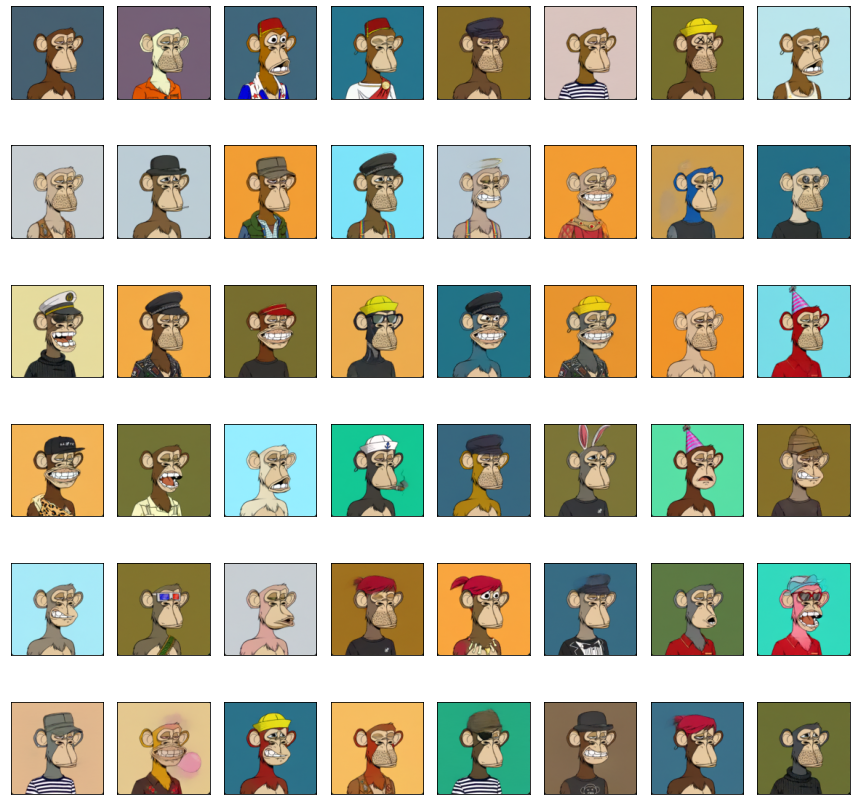

In [33]:
plot_samples(samples, 64)